#### Preparing a dataset for supervised instruction finetuning

In [4]:
import urllib

In [5]:
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)
urllib.request.urlretrieve(url, filename="./data/instruction-data.json")

('./data/instruction-data.json', <http.client.HTTPMessage at 0x794b7ba80c90>)

In [1]:
import json

with open("./data/instruction-data.json", "r", encoding="utf-8") as fp:
    instruction_data = json.load(fp)

print("Total Instructions:", len(instruction_data))
instruction_data[:5]

Total Instructions: 1100


[{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
  'input': 'freind --> friend',
  'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'},
 {'instruction': 'Edit the following sentence for grammar.',
  'input': 'He go to the park every day.',
  'output': 'He goes to the park every day.'},
 {'instruction': 'Convert 45 kilometers to meters.',
  'input': '',
  'output': '45 kilometers is 45000 meters.'},
 {'instruction': "Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.",
  'input': '',
  'output': 'Although it was raining, they went for a walk.'},
 {'instruction': 'What are the first 10 square numbers?',
  'input': '',
  'output': '1, 4, 9, 16, 25, 36, 49, 64, 81, 100.'}]

* Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided

* There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

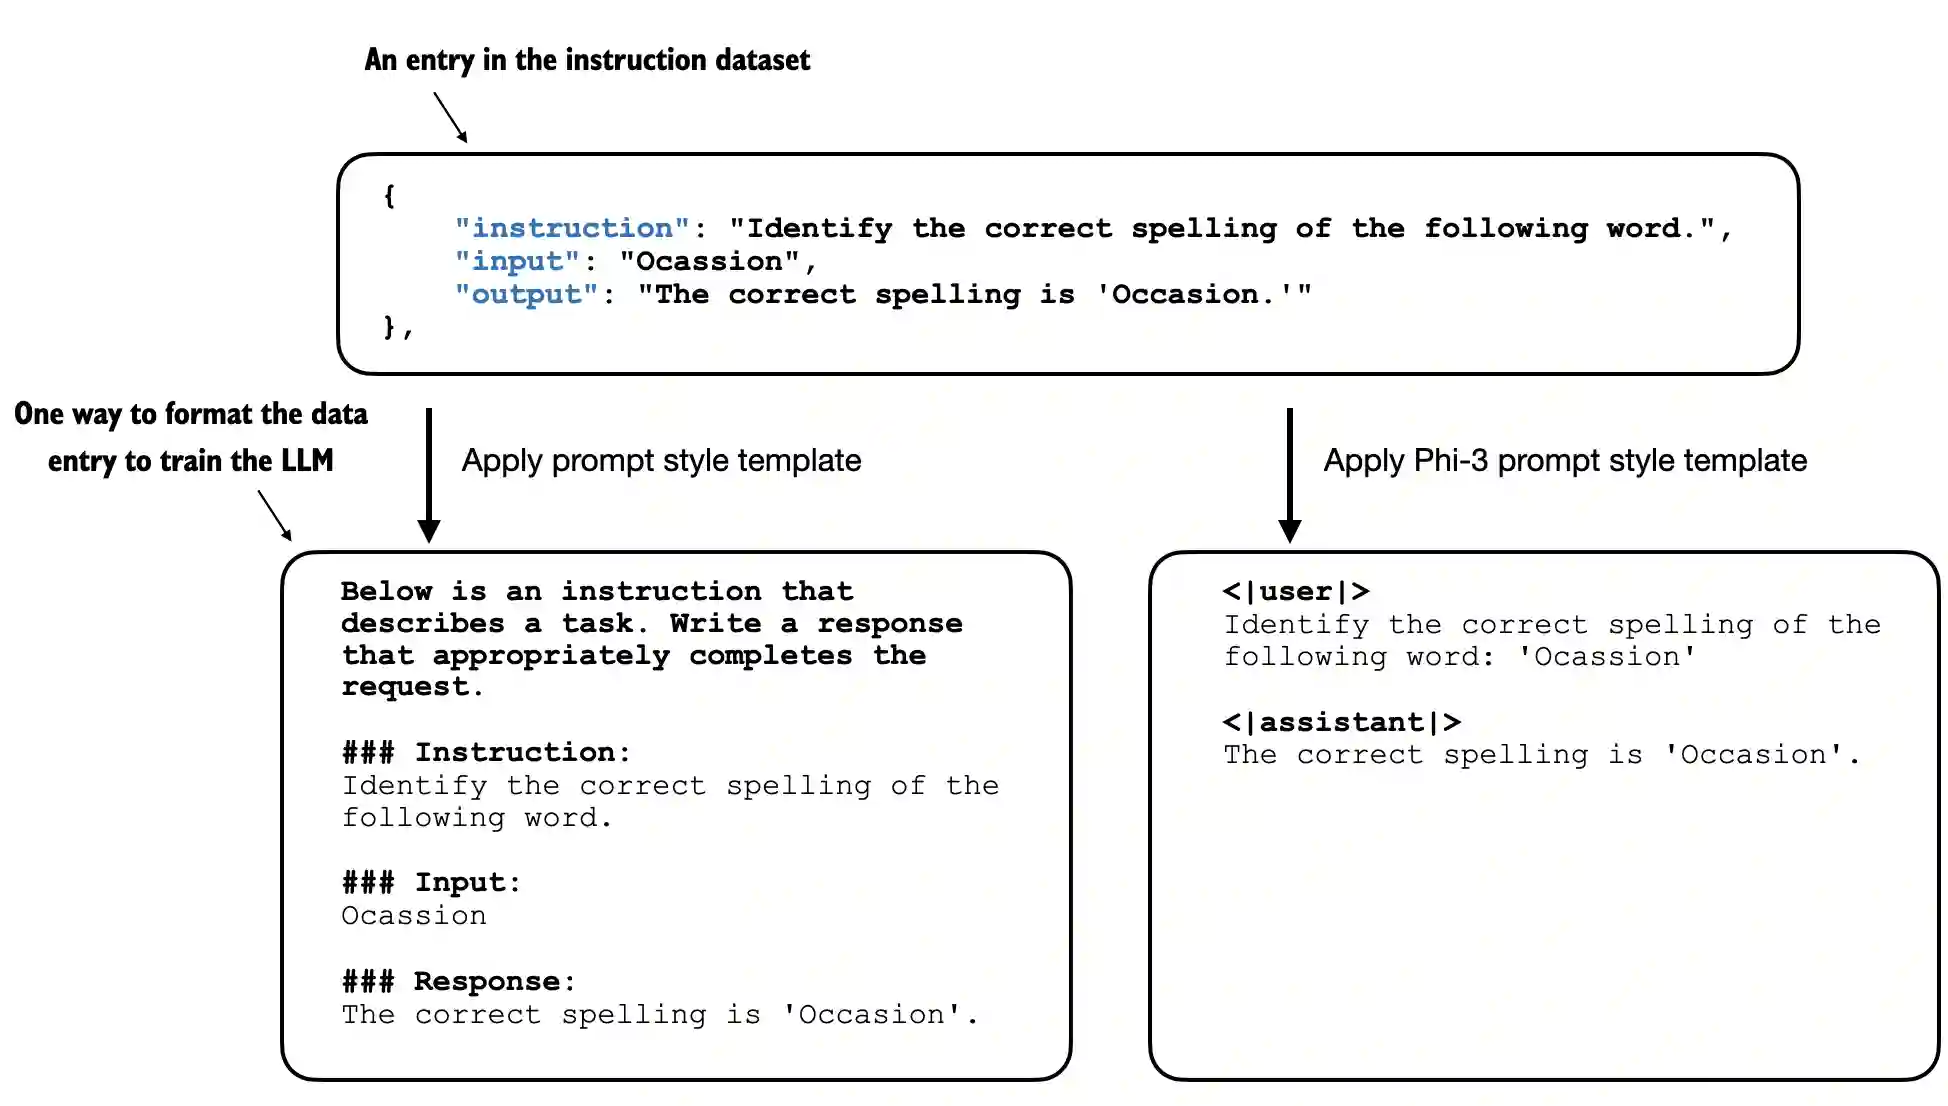

In [7]:
from IPython.display import Image
Image(filename="./images/instruction_finetuning.png", width=600)

* We use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
* Below, we format the input that we will pass as input to the LLM

In [3]:
def format_input(entry: dict):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

def format_response(entry: dict):
    desired_response = f"\n\n### Response:\n{entry['output']}"
    return desired_response


def apply_prompt_template(entry: dict):
    return format_input(entry) + format_response(entry)


In [9]:
sample_entry = instruction_data[1010]
model_input = apply_prompt_template(sample_entry)
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Translate 'Can I have some water?' into French.

### Response:
Puis-je avoir de l'eau?


*  we divide the dataset into a training, validation, and test set

In [10]:
train_portion = int(len(instruction_data) * 0.85)  # 85% for training
test_portion = int(len(instruction_data) * 0.1)    # 10% for testing
val_portion = len(instruction_data) - train_portion - test_portion  # Remaining 5% for validation

train_data = instruction_data[:train_portion]
test_data = instruction_data[train_portion:train_portion + test_portion]
val_data = instruction_data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Organizing data into training batches

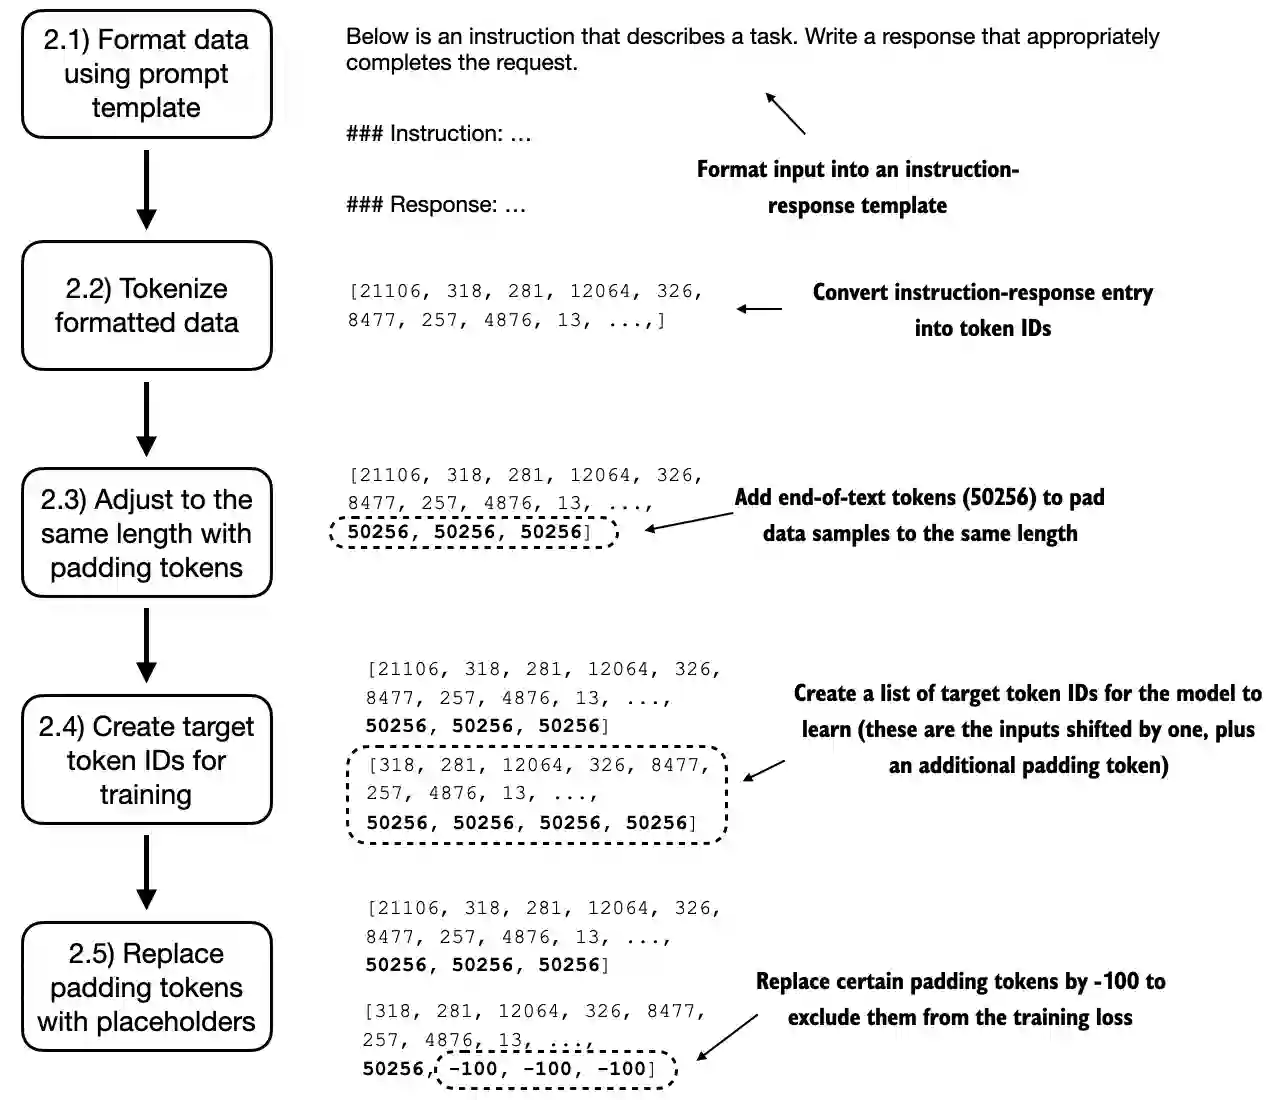

In [12]:
from IPython.display import Image
Image(filename="./images/instruction_finetuning-batching.png", width=600)

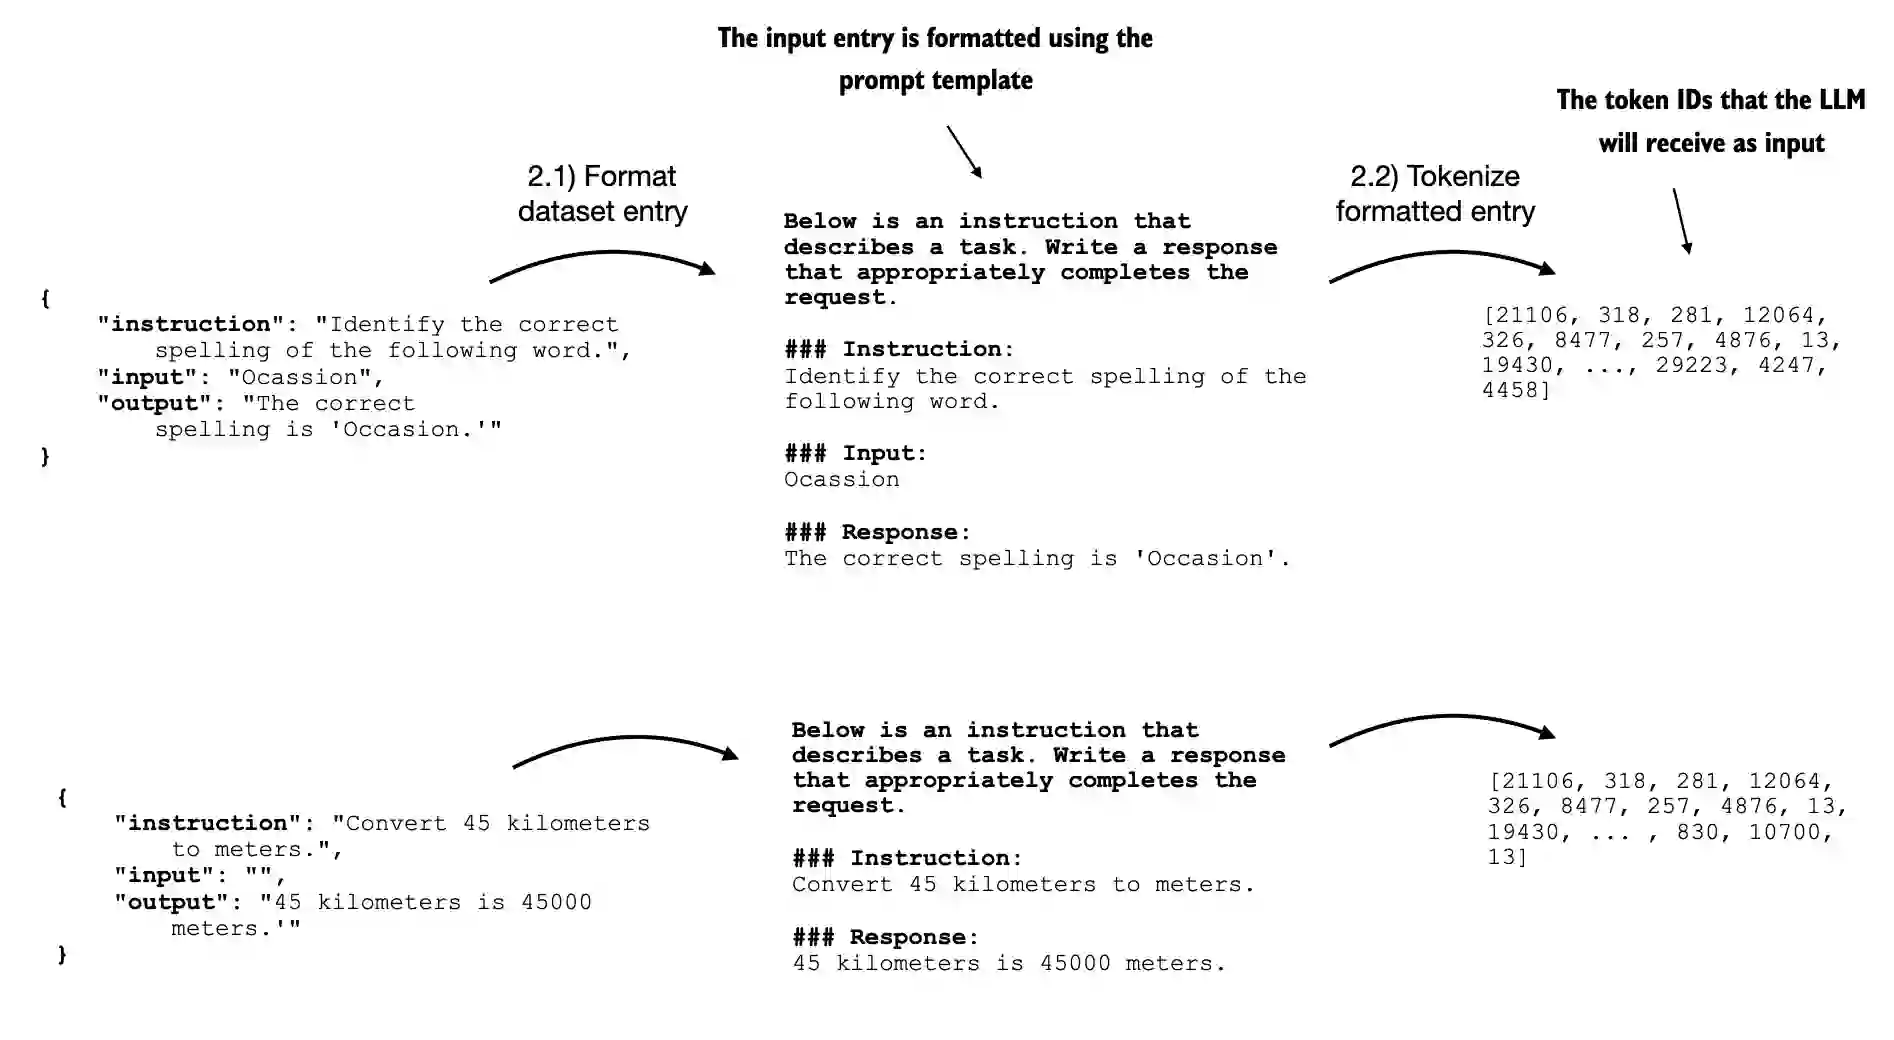

In [13]:
from IPython.display import Image
Image(filename="./images/instruction_finetuning-batching-example.png", width=700)

In [4]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            full_text = apply_prompt_template(entry)
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

* In Classification finetuning, we padded all examples in a dataset to the same length.
  
* Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader

* This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

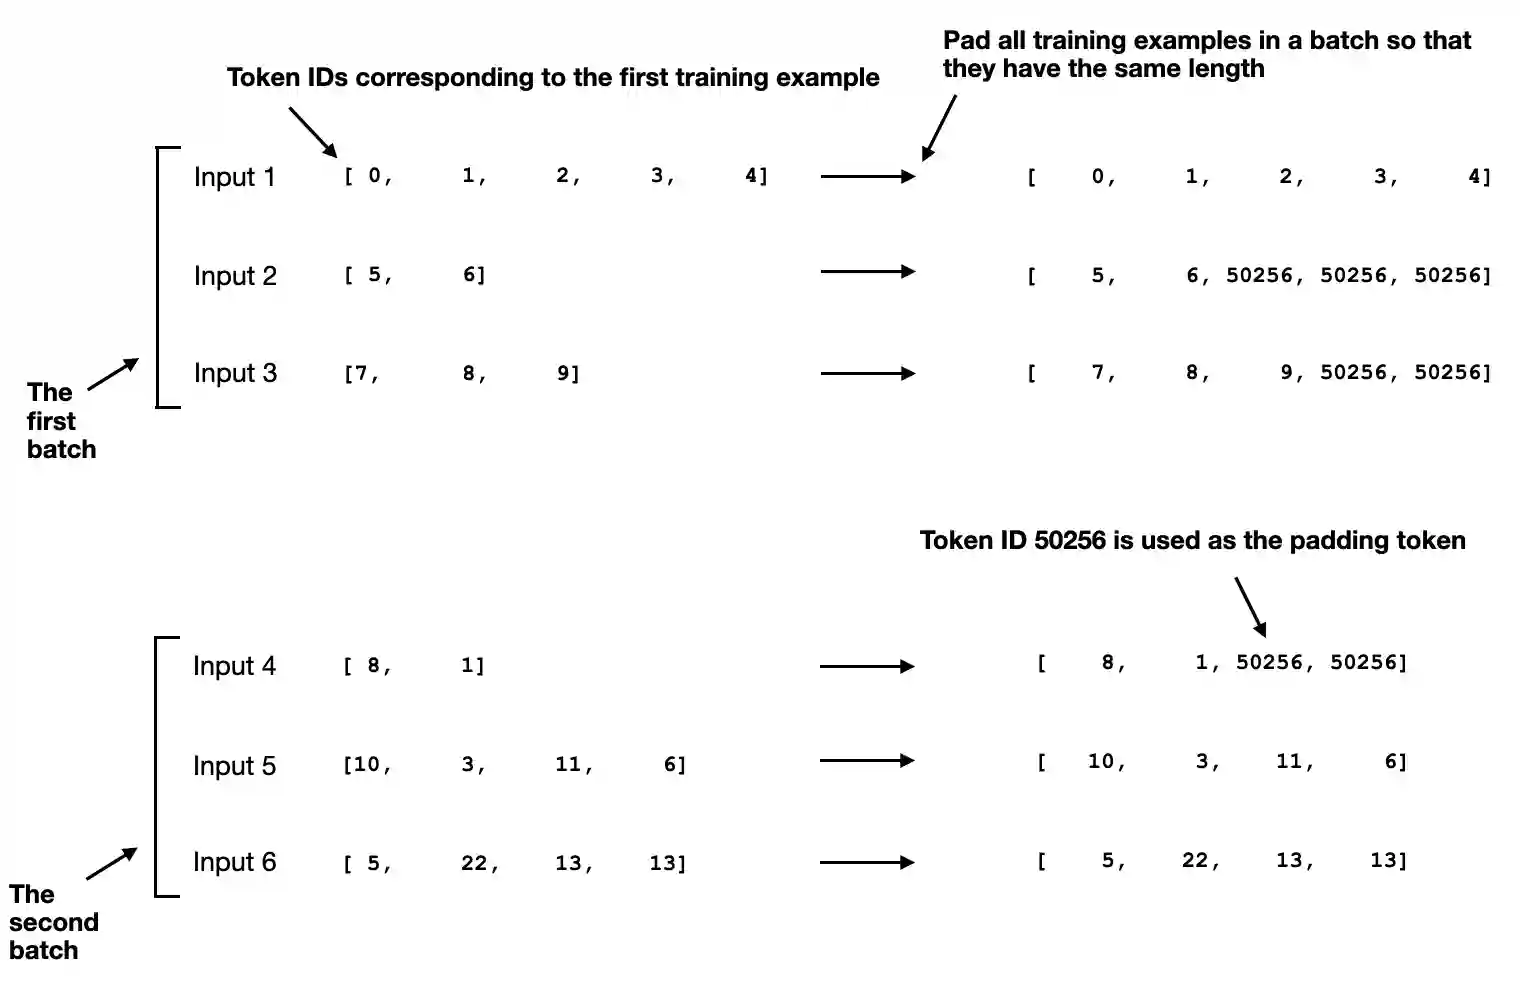

In [15]:
from IPython.display import Image
Image(filename="./images/custom_collate_fn_instruction_finetuning.png", width=700)

In [16]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [17]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


* Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
* Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

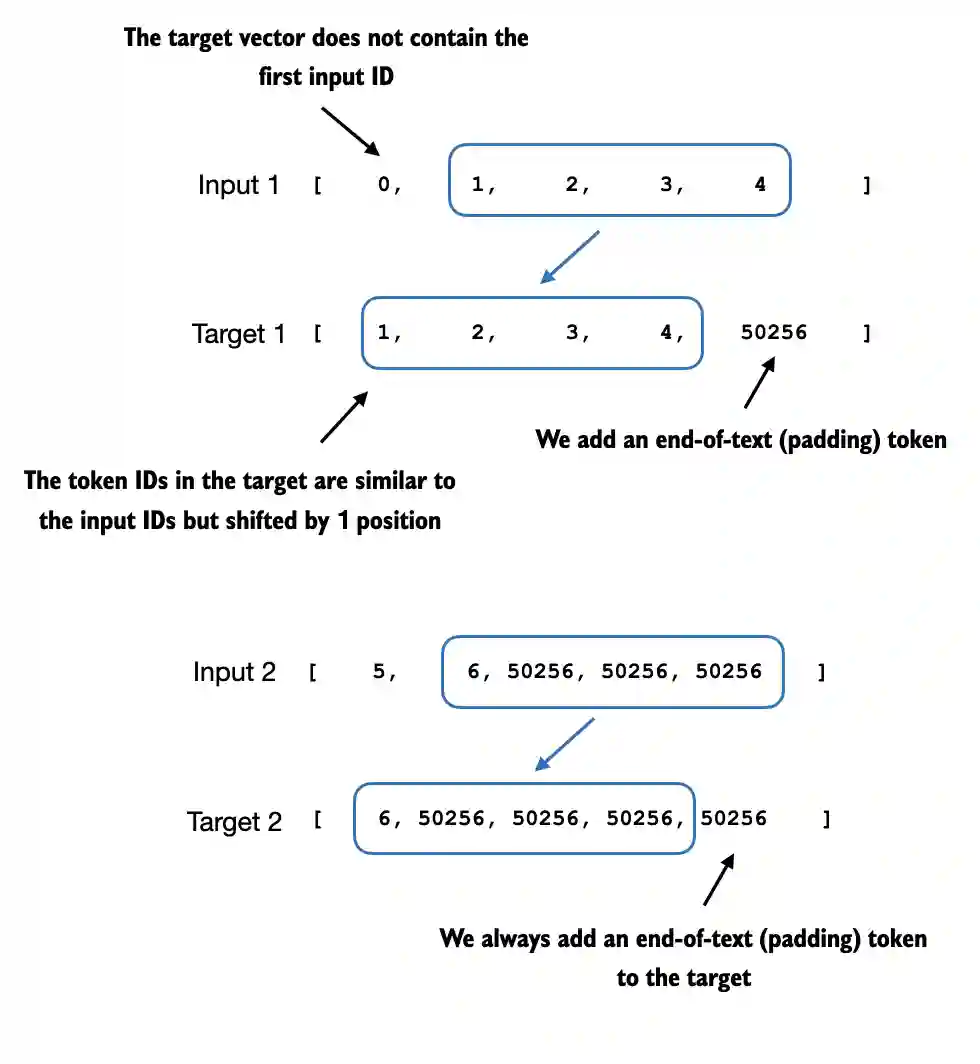

In [19]:
from IPython.display import Image
Image(filename="./images/instruction_finetuning-batching-target.png", width=400)

In [20]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor


In [21]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


* Next, we introduce an ignore_index value to replace all padding token IDs with a new value; the purpose of this ignore_index is that we can ignore padding values in the loss function (more on that later)

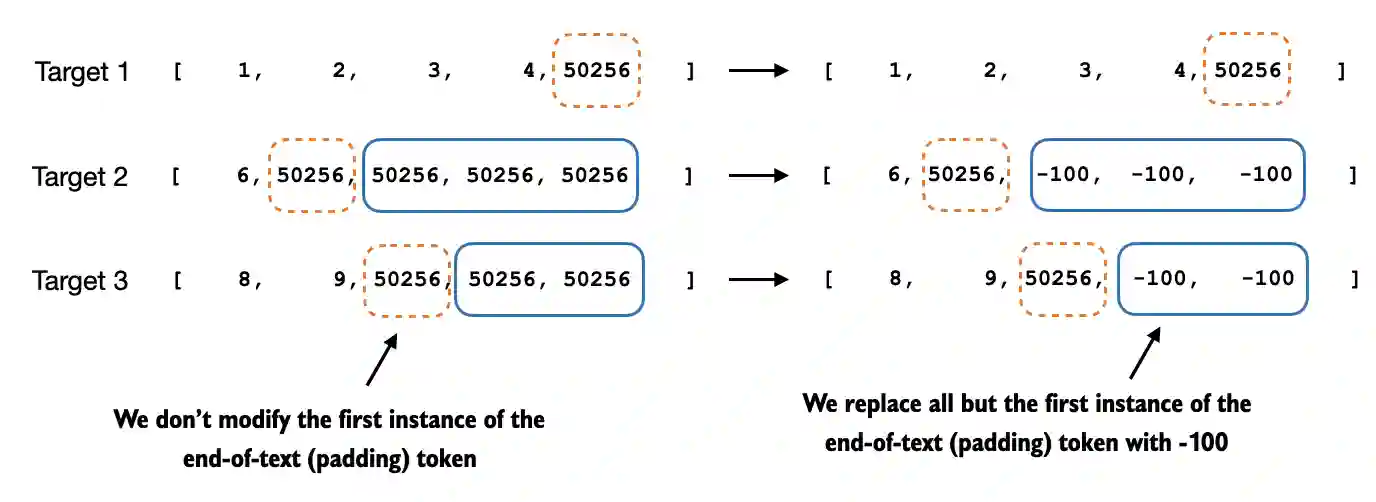

In [23]:
from IPython.display import Image
Image(filename="./images/instruction_finetuning-batching-target-ignore-index.png", width=500)

* (In addition, we also introduce the allowed_max_length in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model)

In [24]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [25]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


* By default, PyTorch has the cross_entropy(..., ignore_index=-100) setting to ignore examples corresponding to the label -100
* Using this -100 ignore_index, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
* However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

#### Masking Instructions (optional)

* In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader exercise after completing the chapter)
* the 2024 Research Paper "Instruction Tuning With Loss over instructions", demonstrated that not masking the instructions benefits the LLM performance. Here we will not apply masking and leave it as an additional exercise.

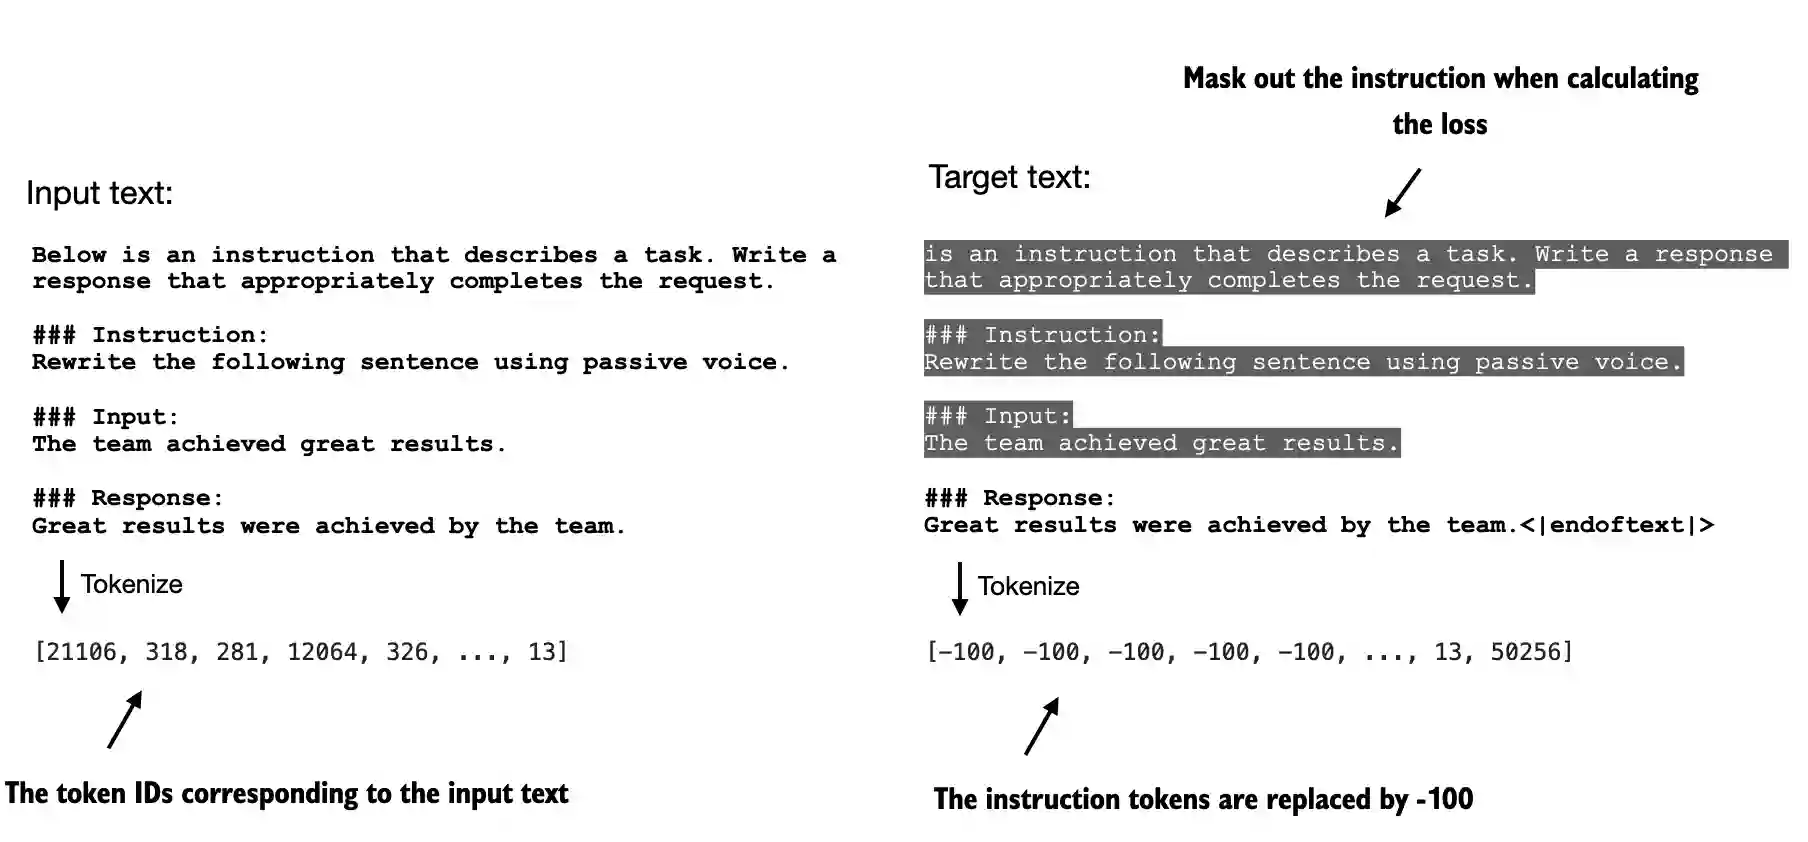

In [27]:
from IPython.display import Image
Image(filename="./images/instruction_finetuning-batching-instruction-mask-out.png", width=600)

In [28]:
# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

# if torch.cuda.is_available():
#    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#    device = torch.device("mps")
# else:
#    device = torch.device("cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Creating data loaders for an instruction dataset

In [43]:
from functools import partial
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import DataLoader

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.eos_token, tokenizer.eos_token_id

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024,
    pad_token_id=tokenizer.eos_token_id
)

num_workers = 0
batch_size = 16

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)


In [44]:
stop_iteration = 10
for X, y in train_loader:
    print(X.shape, y.shape)
    if stop_iteration == 0:
        break
    stop_iteration -= 1

torch.Size([16, 76]) torch.Size([16, 76])
torch.Size([16, 73]) torch.Size([16, 73])
torch.Size([16, 72]) torch.Size([16, 72])
torch.Size([16, 80]) torch.Size([16, 80])
torch.Size([16, 75]) torch.Size([16, 75])
torch.Size([16, 68]) torch.Size([16, 68])
torch.Size([16, 77]) torch.Size([16, 77])
torch.Size([16, 79]) torch.Size([16, 79])
torch.Size([16, 71]) torch.Size([16, 71])
torch.Size([16, 83]) torch.Size([16, 83])
torch.Size([16, 80]) torch.Size([16, 80])


* As we can see based on the output above, all batches have a batch size of 16 but a different length, as expected

In [35]:
X[0]  # single instruction

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 42316,   257,  6827,  1262,   262,  2456,
          705,   620, 12311,  4032,   705, 35231,  4032,   290,   705,  9395,
         3299,  2637,   198,   198, 21017, 18261,    25,   198,  3152, 22445,
           11,   345,   460,  4620,   597,  3061,    13, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256], device='cuda:0')

In [36]:
y[0]

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 42316,   257,  6827,  1262,   262,  2456,   705,
          620, 12311,  4032,   705, 35231,  4032,   290,   705,  9395,  3299,
         2637,   198,   198, 21017, 18261,    25,   198,  3152, 22445,    11,
          345,   460,  4620,   597,  3061,    13, 50256,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100], device='cuda:0')

### Using Pretrained LLM Weights

In [37]:
from transformers import GPT2LMHeadModel

class GPTInstructModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = GPT2LMHeadModel.from_pretrained('gpt2')

    def forward(self, x):
        # X [BS, SEQ]
        x = self.model(x) # BS, SEQ, VOCAB_SIZE
        return x["logits"]

## Sanity Check

In [38]:
import torch.nn.functional as F

class CELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits: torch.Tensor, target: torch.Tensor):
        """
        logits: Logits of shape BATCH_SIZE, SEQ_LENGTH, VOCAB_SIZE
        target: Targets of shape BATCH_SIZE, SEQ_LENGTH
        """
        logits_flatten = logits.flatten(start_dim=0, end_dim=1) # -> BATCH_SIZE * SEQ_LENGTH, VOCB_SIZE
        target_flatten = target.flatten() # -> BATCH_SIZE * SEQ_LENGTH
        return F.cross_entropy(logits_flatten, target_flatten)

loss = CELoss()
model = GPTInstructModel().to(device)

with torch.no_grad():
    model.eval()
    for X, y in val_loader:
        logits = model(X.to(device))
        print(X.shape, y.shape, logits.shape, "CE Loss:", loss(logits, y))
        break

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

torch.Size([4, 62]) torch.Size([4, 62]) torch.Size([4, 62, 50257]) CE Loss: tensor(4.2246, device='cuda:0')


In [40]:
from deepml.tasks import NeuralNetTask

task = NeuralNetTask(model, "./model_wights/instruction_tuning")

In [41]:
from deepml.train import Learner

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)
loss = CELoss()

trainer = Learner(task, optimizer, loss)

In [45]:
trainer.fit(train_loader, val_loader, epochs=10)

Epoch 1/10:



Training    : 100%|██████████| 58/58 [00:19<00:00,  2.81it/s, loss=0.5981]

Validation  :   0%|          | 0/4 [00:00<?, ?it/s]

Validation  :  25%|██▌       | 1/4 [00:00<00:00, 10.73it/s, loss=0.8344]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  9.99it/s, loss=0.8344]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  9.99it/s, loss=0.7836]

Validation  :  75%|███████▌  | 3/4 [00:00<00:00,  9.99it/s, loss=0.7491]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 12.61it/s, loss=0.7491]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 11.92it/s, loss=0.7149]


Training Loss: 0.5981 Validation Loss: 0.7149 [Saving best validation model]
Epoch 2/10:




Training    : 100%|██████████| 58/58 [00:25<00:00,  2.27it/s, loss=0.5981]


Training    :   2%|▏         | 1/58 [00:00<00:19,  3.00it/s]

Training    :   2%|▏         | 1/58 [00:00<00:19,  3.00it/s, loss=0.5012]

Training    :   3%|▎         | 2/58 [00:00<00:19,  2.94it/s, loss=0.5012]

Training    :   3%|▎         | 2/58 [00:00<00:19,  2.94it/s, loss=0.491] 

Training    :   5%|▌         | 3/58 [00:01<00:18,  2.98it/s, loss=0.491]

Training    :   5%|▌         | 3/58 [00:01<00:18,  2.98it/s, loss=0.4954]

Training    :   7%|▋         | 4/58 [00:01<00:18,  2.92it/s, loss=0.4954]

Training    :   7%|▋         | 4/58 [00:01<00:18,  2.92it/s, loss=0.4749]

Training    :   9%|▊         | 5/58 [00:01<00:17,  2.98it/s, loss=0.4749]

Training    :   9%|▊         | 5/58 [00:01<00:17,  2.98it/s, loss=0.4596]

Training    :  10%|█         | 6/58 [00:01<00:17,  3.05it/s, loss=0.4596]

Training    :  10%|█         | 6/58 [00:02<00:17,  3.05it/s, loss=0.4429]

Training    :  12%|█▏        | 7/58

Training Loss: 0.4048 Validation Loss: 0.7479 
Epoch 3/10:



Training    : 100%|██████████| 58/58 [00:20<00:00,  2.77it/s, loss=0.4048]

Training    : 100%|██████████| 58/58 [00:21<00:00,  2.89it/s, loss=0.318] 

Validation  :   0%|          | 0/4 [00:00<?, ?it/s]

Validation  :  25%|██▌       | 1/4 [00:00<00:00,  9.71it/s]

Validation  :  25%|██▌       | 1/4 [00:00<00:00,  9.71it/s, loss=0.9489]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  8.76it/s, loss=0.9489]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  8.76it/s, loss=0.8628]

Validation  :  75%|███████▌  | 3/4 [00:00<00:00,  8.76it/s, loss=0.822] 

Validation  : 100%|██████████| 4/4 [00:00<00:00, 11.67it/s, loss=0.822]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 10.89it/s, loss=0.7847]


Training Loss: 0.3180 Validation Loss: 0.7847 
Epoch 4/10:




Training    : 100%|██████████| 58/58 [00:21<00:00,  2.68it/s, loss=0.318]


Training    :   2%|▏         | 1/58 [00:00<00:20,  2.78it/s]

Training    :   2%|▏         | 1/58 [00:00<00:20,  2.78it/s, loss=0.2576]

Training    :   3%|▎         | 2/58 [00:00<00:19,  2.81it/s, loss=0.2576]

Training    :   3%|▎         | 2/58 [00:00<00:19,  2.81it/s, loss=0.2719]

Training    :   5%|▌         | 3/58 [00:01<00:19,  2.83it/s, loss=0.2719]

Training    :   5%|▌         | 3/58 [00:01<00:19,  2.83it/s, loss=0.2668]

Training    :   7%|▋         | 4/58 [00:01<00:19,  2.82it/s, loss=0.2668]

Training    :   7%|▋         | 4/58 [00:01<00:19,  2.82it/s, loss=0.257] 

Training    :   9%|▊         | 5/58 [00:01<00:18,  2.80it/s, loss=0.257]

Training    :   9%|▊         | 5/58 [00:01<00:18,  2.80it/s, loss=0.2568]

Training    :  10%|█         | 6/58 [00:02<00:18,  2.83it/s, loss=0.2568]

Training    :  10%|█         | 6/58 [00:02<00:18,  2.83it/s, loss=0.2562]

Training    :  12%|█▏        | 7/58 

Training Loss: 0.2781 Validation Loss: 0.8011 
Epoch 5/10:



Training    : 100%|██████████| 58/58 [00:21<00:00,  2.74it/s, loss=0.2781]

Training    : 100%|██████████| 58/58 [00:20<00:00,  3.00it/s, loss=0.247] 

Validation  :   0%|          | 0/4 [00:00<?, ?it/s]

Validation  :  25%|██▌       | 1/4 [00:00<00:00, 10.47it/s, loss=1.0093]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  9.82it/s, loss=1.0093]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  9.82it/s, loss=0.8998]

Validation  :  75%|███████▌  | 3/4 [00:00<00:00,  9.82it/s, loss=0.8622]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 12.39it/s, loss=0.8622]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 11.75it/s, loss=0.8228]


Training Loss: 0.2470 Validation Loss: 0.8228 
Epoch 6/10:




Training    : 100%|██████████| 58/58 [00:31<00:00,  1.84it/s, loss=0.247]


Training    :   2%|▏         | 1/58 [00:00<00:21,  2.66it/s]

Training    :   2%|▏         | 1/58 [00:00<00:21,  2.66it/s, loss=0.1874]

Training    :   3%|▎         | 2/58 [00:00<00:18,  2.96it/s, loss=0.1874]

Training    :   3%|▎         | 2/58 [00:00<00:18,  2.96it/s, loss=0.1982]

Training    :   5%|▌         | 3/58 [00:00<00:17,  3.09it/s, loss=0.1982]

Training    :   5%|▌         | 3/58 [00:00<00:17,  3.09it/s, loss=0.2033]

Training    :   7%|▋         | 4/58 [00:01<00:17,  3.05it/s, loss=0.2033]

Training    :   7%|▋         | 4/58 [00:01<00:17,  3.05it/s, loss=0.203] 

Training    :   9%|▊         | 5/58 [00:01<00:17,  3.07it/s, loss=0.203]

Training    :   9%|▊         | 5/58 [00:01<00:17,  3.07it/s, loss=0.2037]

Training    :  10%|█         | 6/58 [00:01<00:17,  3.04it/s, loss=0.2037]

Training    :  10%|█         | 6/58 [00:01<00:17,  3.04it/s, loss=0.2079]

Training    :  12%|█▏        | 7/58 

Training Loss: 0.2262 Validation Loss: 0.9011 
Epoch 7/10:



Training    : 100%|██████████| 58/58 [00:20<00:00,  2.80it/s, loss=0.2262]

Training    : 100%|██████████| 58/58 [00:21<00:00,  2.78it/s, loss=0.2134]

Validation  :   0%|          | 0/4 [00:00<?, ?it/s]

Validation  :  25%|██▌       | 1/4 [00:00<00:00, 10.21it/s, loss=1.1001]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  9.45it/s, loss=1.1001]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  9.45it/s, loss=0.9818]

Validation  :  75%|███████▌  | 3/4 [00:00<00:00,  9.45it/s, loss=0.9303]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 11.97it/s, loss=0.9303]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 11.37it/s, loss=0.8802]


Training Loss: 0.2134 Validation Loss: 0.8802 
Epoch 8/10:




Training    : 100%|██████████| 58/58 [00:21<00:00,  2.67it/s, loss=0.2134]


Training    :   2%|▏         | 1/58 [00:00<00:22,  2.53it/s]

Training    :   2%|▏         | 1/58 [00:00<00:22,  2.53it/s, loss=0.1873]

Training    :   3%|▎         | 2/58 [00:00<00:20,  2.75it/s, loss=0.1873]

Training    :   3%|▎         | 2/58 [00:00<00:20,  2.75it/s, loss=0.1855]

Training    :   5%|▌         | 3/58 [00:01<00:20,  2.73it/s, loss=0.1855]

Training    :   5%|▌         | 3/58 [00:01<00:20,  2.73it/s, loss=0.1804]

Training    :   7%|▋         | 4/58 [00:01<00:20,  2.62it/s, loss=0.1804]

Training    :   7%|▋         | 4/58 [00:01<00:20,  2.62it/s, loss=0.1801]

Training    :   9%|▊         | 5/58 [00:01<00:19,  2.70it/s, loss=0.1801]

Training    :   9%|▊         | 5/58 [00:01<00:19,  2.70it/s, loss=0.1762]

Training    :  10%|█         | 6/58 [00:02<00:18,  2.76it/s, loss=0.1762]

Training    :  10%|█         | 6/58 [00:02<00:18,  2.76it/s, loss=0.1734]

Training    :  12%|█▏        | 7/5

Training Loss: 0.2004 Validation Loss: 0.9282 
Epoch 9/10:



Training    : 100%|██████████| 58/58 [00:21<00:00,  2.76it/s, loss=0.2004]

Training    : 100%|██████████| 58/58 [00:20<00:00,  2.80it/s, loss=0.1943]

Validation  :   0%|          | 0/4 [00:00<?, ?it/s]

Validation  :  25%|██▌       | 1/4 [00:00<00:00, 10.85it/s, loss=1.1292]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  9.83it/s, loss=1.1292]

Validation  :  50%|█████     | 2/4 [00:00<00:00,  9.83it/s, loss=0.9835]

Validation  :  75%|███████▌  | 3/4 [00:00<00:00,  9.83it/s, loss=0.9326]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 12.76it/s, loss=0.9326]

Validation  : 100%|██████████| 4/4 [00:00<00:00, 12.05it/s, loss=0.8835]


Training Loss: 0.1943 Validation Loss: 0.8835 
Epoch 10/10:




Training    : 100%|██████████| 58/58 [00:20<00:00,  2.82it/s, loss=0.1943]


Training    :   2%|▏         | 1/58 [00:00<00:16,  3.42it/s]

Training    :   2%|▏         | 1/58 [00:00<00:16,  3.42it/s, loss=0.1678]

Training    :   3%|▎         | 2/58 [00:00<00:17,  3.15it/s, loss=0.1678]

Training    :   3%|▎         | 2/58 [00:00<00:17,  3.15it/s, loss=0.1662]

Training    :   5%|▌         | 3/58 [00:00<00:17,  3.11it/s, loss=0.1662]

Training    :   5%|▌         | 3/58 [00:00<00:17,  3.11it/s, loss=0.1698]

Training    :   7%|▋         | 4/58 [00:01<00:17,  3.03it/s, loss=0.1698]

Training    :   7%|▋         | 4/58 [00:01<00:17,  3.03it/s, loss=0.1681]

Training    :   9%|▊         | 5/58 [00:01<00:18,  2.84it/s, loss=0.1681]

Training    :   9%|▊         | 5/58 [00:01<00:18,  2.84it/s, loss=0.1693]

Training    :  10%|█         | 6/58 [00:02<00:18,  2.83it/s, loss=0.1693]

Training    :  10%|█         | 6/58 [00:02<00:18,  2.83it/s, loss=0.173] 

Training    :  12%|█▏        | 7/5

Training Loss: 0.1930 Validation Loss: 0.9348 


Training    : 100%|██████████| 58/58 [00:42<00:00,  1.36it/s, loss=0.193]


In [1]:
import torch
torch.__version__

'2.2.2'

###  Extracting and saving responses

In [63]:
def softmax_with_temperature(logits, temperature: float = 1.0, topk: int = 5):
    topk_logits, _ = torch.topk(logits, topk)
    min_val = topk_logits[:, -1]

    logits = torch.where(logits < min_val, -torch.inf, logits)
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

# Select next token always with max prob using argmax
def generate(model, idx, max_new_tokens, context_size, temperature: float= 1.0, topk:int = 10):
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # last vector
        probas = softmax_with_temperature(logits, temperature, topk)
        idx_next = torch.multinomial(probas, num_samples=1)

        # stop generating response one eos predicted, although you can continue generating text till max_new_tokens
        if idx_next == tokenizer.eos_token_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

###  Test Model Prediction on Sample Instruction

In [80]:
input_text = format_input(val_data[5])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provide a synonym for 'quick'.


In [81]:
input_ids = torch.tensor(tokenizer(input_text)["input_ids"]).unsqueeze(0).to(device)
input_ids.shape

torch.Size([1, 33])

In [82]:
output_token_ids = generate(model, input_ids, max_new_tokens=100, context_size=1024)
output_text = tokenizer.decode(output_token_ids[0])
print(output_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provide a synonym for 'quick'.

### Response:
A synonym for 'quick' is 'fast'.


In [83]:
# skip instruction tokens from output
output_text = output_text[len(input_text):]
# replace response text
output_text = output_text.replace("### Response:", "").strip()
output_text

"A synonym for 'quick' is 'fast'."

* As you can see, though it is overfitting on training set, model correctly predicted the output instruction.


* Here we will evaluate our trained LLM model on test set.
* First we will be saving our test set response for scoring in the next section.

In [86]:

torch.manual_seed(123)

for entry in test_data[:5]:

    input_text = format_input(entry)
    input_ids = torch.tensor(tokenizer(input_text)["input_ids"]).unsqueeze(0).to(device)
    token_ids = generate(
        model=model,
        idx=input_ids,
        max_new_tokens=256,
        context_size=1024
    )
    output_token_ids = generate(model, input_ids, max_new_tokens=100, context_size=1024)
    output_text = tokenizer.decode(output_token_ids[0])
    # skip instruction tokens from output
    output_text = output_text[len(input_text):]
    # replace response text
    output_text = output_text.replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {output_text}")
    print("-------------------------------------")


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud is typically associated with thunderstorms.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice

* Most importantly, we can see that model evaluation is not as straightforward as in the previous chapter, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy

* In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches

    * short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", https://arxiv.org/abs/2009.03300), which test the knowledge of a model
    * human preference comparison to other LLMs, such as LMSYS chatbot arena (https://arena.lmsys.org)
    * automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval (https://tatsu-lab.github.io/alpaca_eval/)

* In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset

* For this, we add the model response to the test_data dictionary and save it as a "instruction-data-with-response.json" file for record-keeping so that we can load and analyze it in separate Python sessions if needed

In [87]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)
    input_ids = torch.tensor(tokenizer(input_text)["input_ids"]).unsqueeze(0).to(device)
    token_ids = generate(
        model=model,
        idx=input_ids,
        max_new_tokens=256,
        context_size=1024
    )
    output_token_ids = generate(model, input_ids, max_new_tokens=100, context_size=1024)
    output_text = tokenizer.decode(output_token_ids[0])
    # skip instruction tokens from output
    output_text = output_text[len(input_text):]
    # replace response text
    output_text = output_text.replace("### Response:", "").strip()

    test_data[i]["model_response"] = output_text


with open("./data/instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [00:53<00:00,  2.06it/s]


In [9]:
test_data[50:55]

[{'instruction': 'Edit the given text to ensure all plural nouns are spelled correctly.',
  'input': 'The birds sings beautiful songs.',
  'output': 'The birds sing beautiful songs.',
  'model_response': 'The birds singing along with the sunset.'},
 {'instruction': 'Transform the following sentence into a question using "could."',
  'input': 'You can help me tomorrow.',
  'output': 'Could you help me tomorrow?',
  'model_response': 'Could you help me?'},
 {'instruction': 'Classify the following items: bicycle, rose, tiger.',
  'input': '',
  'output': 'Vehicles: Bicycle\nPlants: Rose\nAnimals: Tiger',
  'model_response': 'Animals: Tiger\nPlants: Rose\nElectronics: Laptop'},
 {'instruction': "Define the term 'irony'.",
  'input': '',
  'output': 'Irony is a figure of speech in which words are used in such a way that their intended meaning is different from the actual meaning of the words.',
  'model_response': "The choir's voices blended in perfect harmony."},
 {'instruction': "Translat

### Evaluating the finetuned LLM

* Most importantly, we can see that model evaluation is not as straightforward as in the previous chapter, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy


* In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", https://arxiv.org/abs/2009.03300), which test the knowledge of a model 
  
* human preference comparison to other LLMs, such as LMSYS chatbot arena (https://arena.lmsys.org)

* automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval (https://tatsu-lab.github.io/alpaca_eval/)

*In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset

* In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM

* In particular, we use an instruction-finetuned 8-billion-parameter Llama 3 model by Meta AI that can be run locally via ollama (https://ollama.com)

* (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the llm-instruction-eval-openai.ipynb notebook)

* Ollama is an application to run LLMs efficiently

* It is a wrapper around llama.cpp (https://github.com/ggerganov/llama.cpp), which implements LLMs in pure C/C++ to maximize efficiency

* Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs

* Before running the code below, install ollama by visiting https://ollama.com and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)


In [ ]:
# 8B model
!ollama run llama3

* The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section

In [2]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [3]:
import json
from tqdm import tqdm

file_path = "./data/instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [4]:
print(format_input(test_data[0]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.


In [5]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("Who are you?", model)
print(result)

I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but a computer program designed to simulate conversation and answer questions to the best of my ability based on my training.

My primary function is to provide information and assist with tasks through text-based conversations. I can generate responses to a wide range of topics, from science and history to entertainment and culture. I can also help with language-related tasks such as language translation, grammar correction, and text summarization.

I'm constantly learning and improving my abilities based on the interactions I have with users like you. So, feel free to ask me anything, and I'll do my best to provide a helpful and accurate response!


In [6]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as an ox.

Score:
>> I'd rate this model response a 20 out of 100.

Here's why:

* The instruction asks for a simile that compares the car's speed to something else, using "as" or "like".
* An ox is not typically associated with speed, so the comparison doesn't make sense in this context.
* Lightning, on the other hand, is often used as a metaphor for speed and swiftness, making it a more fitting comparison.

The model response could be improved by choosing a more relevant and common simile that accurately conveys the idea of the car's speed.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud typically associated with thunderstorms is a type of cumulus pattern of 10-5 cm.

Score:
>> I'd rate this model response a 20 out of 100.

Here's why:

* The response doesn't directly answer the qu